In [1]:
import csv
import pandas as pd
import numpy as np
import math
import scipy.stats as st
import itertools as it
import numpy.matlib as nm
from sklearn import metrics
import sklearn.model_selection as ms
import sklearn.metrics as metrics
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn import linear_model
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn 
from scipy.stats import poisson
import statsmodels.api as sm
from numpy import random as rn
from scipy import stats
from fitter import Fitter, get_common_distributions
from scipy.stats import weibull_max
from tqdm import tqdm
from scipy.integrate import quad
from ipywidgets import interact, FloatSlider, IntSlider
import scipy.interpolate as interp
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

In [2]:
short_rates = pd.read_csv('short_rates.csv', sep=';', decimal=',')
short_rates[:2506]

,tradedate,tradetime,period_0.25
0,06.01.2014,12:21:16,5.92
1,08.01.2014,12:41:22,5.92
2,09.01.2014,18:38:19,5.78
3,10.01.2014,18:38:17,5.70
4,13.01.2014,18:37:26,5.81
...,...,...,...
2501,25.12.2023,18:39:59,13.78
2502,26.12.2023,18:39:59,13.33
2503,27.12.2023,18:39:57,13.22
2504,28.12.2023,18:39:57,12.78


Time interval: δt=0.08333333333333333 years
Simulation path M=1000000


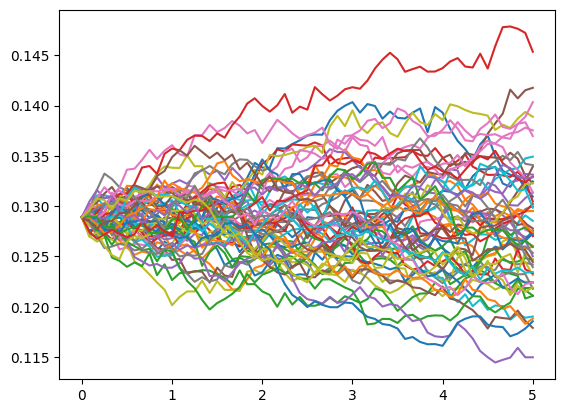

The expected value for the interest rate is: 12.769%
The standard error of sample mean is: 0.0006%
Lower 99% is: 12.767%
Upper 99% is: 12.770%


In [3]:
'''Parameters a, b, σ for Cox-Ingersoll-Ross colibrated in excel: CIR_Calibration.xlsx'''

a = 0.004924420
b = 0.079128172
σ = 0.007782762

r0 = 0.1289  # as of 03.01.2024
T = 5
N = 60
δt = T/N
print(f"Time interval: δt={δt} years")
M = 1000000
print(f"Simulation path M={M}")
dz = rn.randn(M,N)
r = r0*np.ones((M,N+1))
for i in range(0,N):
    r[:,i+1] = r[:,i] + a*(b-r[:,i])*δt + σ*np.sqrt(r[:,i])*dz[:,i]*np.sqrt(δt)
plt.show()

a = [ rn.randint(0,M) for j in range(1,60)]

for runer in a:
    plt.plot(np.arange(0,T+δt,δt),r[runer])
plt.show()
V = (r[:,-1])
print("The expected value for the interest rate is:","{:.3%}".format(np.mean(V)))
print("The standard error of sample mean is:", "{:.4%}".format(np.std(V)/np.sqrt(M)))
from scipy.stats import norm
def normsinv(x):
    x = norm.ppf(x)
    return (x)

z = normsinv(0.995)
μ = np.mean(V)
SE = np.std(V)/np.sqrt(M)

print("Lower 99% is:","{:.3%}".format( (μ-z*SE) ))
print("Upper 99% is:","{:.3%}".format( (μ+z*SE) ))

In [4]:
a = 0.004924420
b = 0.079128172
σ = 0.007782762

r0 = 0.1289  # as of 03.01.2024
T = 5
N = 60
δt = 0.08333333333333333
M = 1000000
dz = rn.randn(M,N)
r = r0*np.ones((M,N+1))

for i in range(0,N):
    r[:,i+1] = r[:,i] + a*(b-r[:,i])*δt + σ*np.sqrt(r[:,i])*dz[:,i]*np.sqrt(δt)

rate = []
years = []
for i in range(0,61):
    rate.append(np.mean(r[:,i]))
    years.append(i/12)

In [6]:
df = pd.read_excel(io='Data.xlsx',sheet_name='UFD', usecols = 'A:DK')
df.head(101)

,region,t_2003,n_2003,b_2003,d_2003,inj_2003,pr_2003,t_2004,n_2004,b_2004,...,b_2021,d_2021,inj_2021,pr_2021,t_2022,n_2022,b_2022,d_2022,inj_2022,pr_2022
0,Курганская область,3,2,0,9,211,0,1,3,0,...,0,5,10,5610.162,1,1,0,2,248,332.9759
1,Свердловская область,13,0,1,21,55,0,36,11,4,...,2,17,524,953.314,2,1,0,2,8,0.0000
2,Тюменская область,2,0,0,6,1,0,7,1,0,...,1,0,0,16.150,0,0,0,0,0,0.0000
3,Челябинская область,8,2,2,10,171,0,13,11,1,...,1,7,9,863.213,0,0,0,0,0,0.0000
4,Ханты-Мансийский автономный округ – Югра,10,0,0,16,46,0,11,17,1,...,1,2,17,0.000,2,2,0,10,202,0.0000
5,Ямало-Ненецкий автономный округ,4,0,0,0,0,0,3,1,0,...,0,0,0,0.000,0,0,0,0,0,0.0000


In [7]:
df.describe()

,t_2003,n_2003,b_2003,d_2003,inj_2003,pr_2003,t_2004,n_2004,b_2004,d_2004,...,b_2021,d_2021,inj_2021,pr_2021,t_2022,n_2022,b_2022,d_2022,inj_2022,pr_2022
count,6.000000,6.000000,6.00000,6.000000,6.000000,6.0,6.000000,6.000000,6.000000,6.000000,...,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,6.0,6.000000,6.000000,6.000000
mean,6.666667,0.666667,0.50000,10.333333,80.666667,0.0,11.833333,7.333333,1.000000,28.833333,...,0.833333,5.166667,93.333333,1240.473167,0.833333,0.666667,0.0,2.333333,76.333333,55.495983
std,4.366539,1.032796,0.83666,7.393691,89.287550,0.0,12.687264,6.623192,1.549193,22.780840,...,0.752773,6.431692,211.082606,2186.114393,0.983192,0.816497,0.0,3.881580,116.113163,135.936842
min,2.000000,0.000000,0.00000,0.000000,0.000000,0.0,1.000000,1.000000,0.000000,16.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
25%,3.250000,0.000000,0.00000,6.750000,12.250000,0.0,4.000000,1.500000,0.000000,18.250000,...,0.250000,0.500000,2.250000,4.037500,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
50%,6.000000,0.000000,0.00000,9.500000,50.500000,0.0,9.000000,7.000000,0.500000,20.000000,...,1.000000,3.500000,9.500000,439.681500,0.500000,0.500000,0.0,1.000000,4.000000,0.000000
75%,9.500000,1.500000,0.75000,14.500000,142.000000,0.0,12.500000,11.000000,1.000000,23.250000,...,1.000000,6.500000,15.250000,930.788750,1.750000,1.000000,0.0,2.000000,153.500000,0.000000
max,13.000000,2.000000,2.00000,21.000000,211.000000,0.0,36.000000,17.000000,4.000000,75.000000,...,2.000000,17.000000,524.000000,5610.162000,2.000000,2.000000,0.0,10.000000,248.000000,332.975900


In [8]:
'''Number of Technogenic and Natural in each year'''
t_n = []

t_n.append(sum(df["t_2022"]+df["n_2022"]))
t_n.append(sum(df["t_2021"]+df["n_2021"]))
t_n.append(sum(df["t_2020"]+df["n_2020"]))
t_n.append(sum(df["t_2019"]+df["n_2019"]))
t_n.append(sum(df["t_2018"]+df["n_2018"]))
t_n.append(sum(df["t_2017"]+df["n_2017"]))
t_n.append(sum(df["t_2016"]+df["n_2016"]))
t_n.append(sum(df["t_2015"]+df["n_2015"]))
t_n.append(sum(df["t_2014"]+df["n_2014"]))

'''Claim size'''

ips = [1.0985, 1.1303, 1.0574, 1.0241, 1.0327, 1.0311, 1.0421, 1.0703, 1.0994] # inflation in region 

pr = []

pr.append(sum(df["pr_2022"])*math.prod(ips[8:]))
pr.append(sum(df["pr_2021"])*math.prod(ips[7:]))
pr.append(sum(df["pr_2020"])*math.prod(ips[6:]))
pr.append(sum(df["pr_2019"])*math.prod(ips[5:]))
pr.append(sum(df["pr_2018"])*math.prod(ips[4:]))
pr.append(sum(df["pr_2017"])*math.prod(ips[3:]))
pr.append(sum(df["pr_2016"])*math.prod(ips[2:]))
pr.append(sum(df["pr_2015"])*math.prod(ips[1:]))
pr.append(sum(df["pr_2014"])*math.prod(ips))

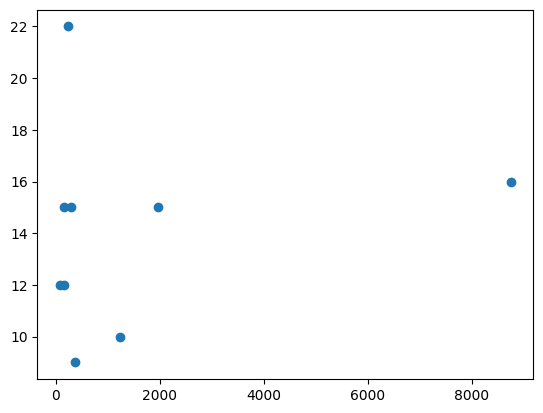

In [9]:
plt.scatter(pr, t_n)

In [10]:
np.mean(t_n)

14.0

In [11]:
'''average claim size for one disaster'''
one_pr = [int(p) / int(t) for p,t in zip(pr, t_n)]
print(one_pr)
np.mean(one_pr)

[40.666666666666664, 547.3125, 20.0, 13.083333333333334, 6.75, 124.2, 131.4, 11.045454545454545, 10.6]


100.56199494949495

2024-05-10 02:33:17.803 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted expon distribution with error=0.004721)
2024-05-10 02:33:17.817 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted norm distribution with error=0.005863)
2024-05-10 02:33:17.823 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted powerlaw distribution with error=0.003296)
2024-05-10 02:33:17.831 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted gamma distribution with error=0.002447)
2024-05-10 02:33:17.840 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted cauchy distribution with error=0.003217)
2024-05-10 02:33:17.843 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted rayleigh distribution with error=0.005753)
2024-05-10 02:33:17.850 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted lognorm distribution with error=0.002553)
2024-05-10 02:33:17.853 | INFO     | fitter.fitter:_fit_single_distribution:337 - Fitted 

,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
genextreme,0.001835,1589.508091,1590.099765,inf,0.147569,0.973488
t,0.001860,1788.918623,1789.510297,inf,0.340920,0.195159
pareto,0.001876,1596.513657,1597.105331,inf,0.164893,0.935492
gamma,0.002447,1700.324449,1700.916122,inf,0.231302,0.641427
lognorm,0.002553,1655.937793,1656.529467,inf,0.439753,0.042174


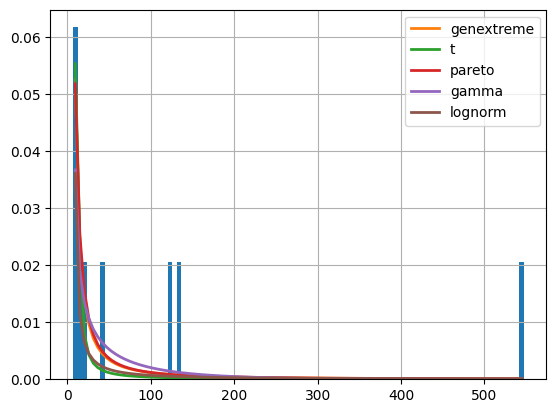

In [12]:
from fitter import Fitter, get_common_distributions


#Organize Data - from question
SR_y = pd.Series(one_pr, name="one_pr (Target Vector Distribution)")


# fitter
distributions_set = get_common_distributions()
distributions_set.extend(['arcsine', 'cosine', 'expon', 'weibull_max', 'weibull_min', 
                          'dweibull', 't', 'pareto', 'exponnorm', 'lognorm',
                          "norm", "exponweib", "weibull_max", "weibull_min", "pareto", "genextreme"])  

f = Fitter(SR_y, distributions = distributions_set) 
f.fit()
f.summary()

In [13]:
f.fitted_param

{'norm': (100.56199494949495, 164.56441331157785),
 'expon': (6.75, 93.81199494949495),
 'powerlaw': (0.1392168276367996, 6.749999999999999, 540.5625000000001),
 'lognorm': (4.090633252632957, 6.749999876641452, 2.2821294678936255),
 'cauchy': (13.691324197686548, 11.014859508427648),
 'gamma': (0.4525105575573649, 6.749999999999998, 95.20547401060364),
 'rayleigh': (-124.29196851656236, 197.02886973103568),
 'chi2': (0.9105955220649462, 6.749999999999999, 172.79609516356214),
 'uniform': (6.75, 540.5625),
 'arcsine': (-46.39365663060048, 593.7061566306006),
 'cosine': (150.69378352823074, 161.93308431600224),
 'exponpow': (0.5913516849433161, 6.749999999999998, 203.12209359323606),
 'weibull_max': (0.1554641583068555, 547.3125000000001, 1.728049615188704),
 'pareto': (0.6237239271843653, -0.4173780445425326, 7.167378044542532),
 'weibull_min': (0.5591784764272401, 6.749999999999998, 167.24956077806843),
 'dweibull': (0.627561845258789, 11.045454545454547, 101.89773508704727),
 'exponn

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


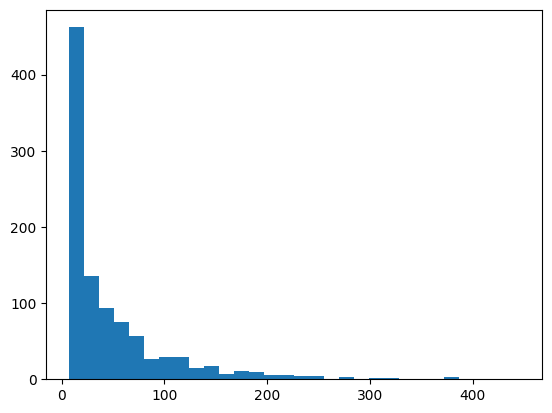

In [14]:
from scipy.stats import gamma

r = gamma.rvs(0.4525105575573649, 6.749999999999998, 95.20547401060364, size=1000)

abs_r = []

for i in r:
    if i >= 0:
        abs_r.append(i)
    if i < 0:
        abs_r.append(0)
        
plt.hist(abs_r, bins=30, histtype="stepfilled")
#plt.set_xlim([x[0], x[-1]])
plt.legend(loc='best', frameon=False)
plt.show()

((array([-3.19758950e+00, -2.93237785e+00, -2.78437841e+00, -2.67999560e+00,
         -2.59855946e+00, -2.53139899e+00, -2.47402263e+00, -2.42379214e+00,
         -2.37902149e+00, -2.33856546e+00, -2.30160949e+00, -2.26755284e+00,
         -2.23593934e+00, -2.20641415e+00, -2.17869564e+00, -2.15255643e+00,
         -2.12781017e+00, -2.10430217e+00, -2.08190261e+00, -2.06050135e+00,
         -2.04000420e+00, -2.02032992e+00, -2.00140792e+00, -1.98317650e+00,
         -1.96558137e+00, -1.94857451e+00, -1.93211325e+00, -1.91615948e+00,
         -1.90067901e+00, -1.88564107e+00, -1.87101783e+00, -1.85678408e+00,
         -1.84291686e+00, -1.82939524e+00, -1.81620005e+00, -1.80331371e+00,
         -1.79072004e+00, -1.77840415e+00, -1.76635224e+00, -1.75455157e+00,
         -1.74299028e+00, -1.73165738e+00, -1.72054262e+00, -1.70963644e+00,
         -1.69892989e+00, -1.68841463e+00, -1.67808281e+00, -1.66792707e+00,
         -1.65794051e+00, -1.64811661e+00, -1.63844924e+00, -1.62893261e+00,

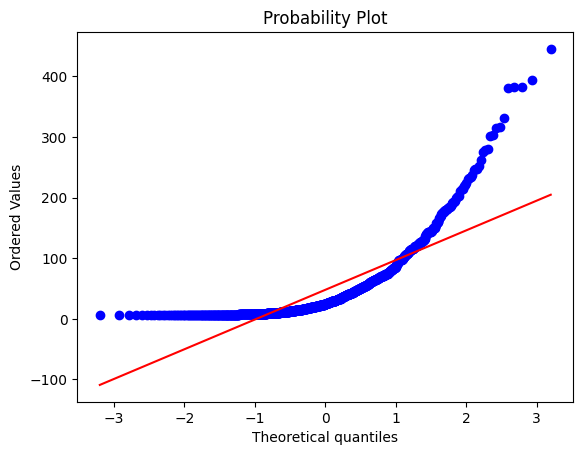

In [15]:
stats.probplot(abs_r, plot=plt)

# All years

In [16]:
claims = {}
for t in tqdm(years):
    claims_t = []
    for i in range(10000):
        rvs = poisson.rvs(14.0*t)*gamma.rvs(0.4525105575573649, 6.749999999999998, 95.20547401060364)
        if rvs >= 0:
            claims_t.append(rvs)
        if rvs < 0:
            claims_t.append(0)
        claims[f'X_{t}'] = claims_t

100%|███████████████████████████████████████████| 61/61 [00:30<00:00,  2.00it/s]


In [17]:
sorted_claims = {k: sorted(v) for k, v in claims.items()}

In [18]:
cdf_all = pd.DataFrame(sorted_claims)
cdf_all

,X_0.0,X_0.08333333333333333,X_0.16666666666666666,X_0.25,X_0.3333333333333333,X_0.4166666666666667,X_0.5,X_0.5833333333333334,X_0.6666666666666666,X_0.75,...,X_4.25,X_4.333333333333333,X_4.416666666666667,X_4.5,X_4.583333333333333,X_4.666666666666667,X_4.75,X_4.833333333333333,X_4.916666666666667,X_5.0
0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.753683,7.985043,...,239.040547,259.145590,257.702619,256.574329,266.028286,300.674413,257.663690,291.356036,284.838625,306.886321
1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.940930,8.358329,...,249.817318,264.204238,266.482695,258.068581,278.048250,305.727225,304.595802,325.380860,304.843008,313.384174
2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.754314,13.513158,13.532504,...,249.990417,271.146146,290.260313,284.662410,284.415931,308.575823,306.556925,329.475096,311.229574,315.708509
3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.803434,14.039138,13.785943,...,259.241369,277.187815,290.284120,293.933963,297.003079,310.520636,325.379207,331.163575,312.668258,319.756988
4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.942392,14.137883,16.631319,...,265.467063,279.395466,292.314176,295.994511,297.042205,311.208498,326.592345,332.142409,321.663590,325.270869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,1344.537617,2707.876896,3987.405027,3227.418394,4495.960269,5391.814145,6289.779601,6023.347180,7598.204723,...,35065.002137,39341.794182,38432.435279,33361.317358,37011.818762,41664.000132,39811.928525,37172.850732,37695.939231,40959.672460
9996,0.0,1442.012860,2741.505001,4098.311912,3535.450790,4895.207765,5513.257080,6376.235576,6147.157435,7649.091937,...,37968.404839,39522.725487,38521.603943,34149.267989,39452.135068,44170.537833,41596.815595,39553.280118,38886.355593,44516.503352
9997,0.0,1443.413104,2743.217345,4129.549295,3590.138490,5432.752195,5696.283423,6481.797646,6644.082655,7796.872736,...,41189.266773,42893.479857,42131.142293,36769.935950,40791.217484,44977.387154,43871.795746,39661.859797,38985.716607,45675.967530
9998,0.0,1499.638186,2810.685635,4212.683096,5143.332539,5821.997056,5803.535267,6516.242957,6807.308272,7853.330023,...,41318.051720,44594.911873,42734.950272,38836.162720,50900.012733,50843.849335,46138.566910,42977.774709,42982.377741,48500.351125


In [19]:
def integrand(x):
    return a

prob = []

for i in range(1,10001):
    prob.append(i/10000)

for i in years:
    cdf_all[f'prob_{i}'] = prob
    
for i in years:
    cdf_all[f'prob_{i}'][(cdf_all[f'X_{i}']==0)] = 0

n= -1
for i in years:
    n+=1
    cdf_all[f'rate_{i}'] = rate[n]

n= -1
for i in years:
    n+=1
    a = rate[n]
    cdf_all[f'discount_{i}'] = math.exp(-quad(integrand, 0, i)[0])

for i in years:
    cdf_all[f'V_{i}'] = cdf_all[f'discount_{i}']*cdf_all[f'prob_{i}']

/var/folders/wz/yjw7nyq11_q0mc4m8zh725nm0000gn/T/ipykernel_97531/548078112.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf_all[f'rate_{i}'] = rate[n]
/var/folders/wz/yjw7nyq11_q0mc4m8zh725nm0000gn/T/ipykernel_97531/548078112.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  cdf_all[f'rate_{i}'] = rate[n]
/var/folders/wz/yjw7nyq11_q0mc4m8zh725nm0000gn/T/ipykernel_97531/548078112.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

In [20]:
X_0 = []
Y_0 = []
Z_0 = []

for i in years:
    for n in cdf_all[f'X_{i}'].tolist():
        X_0.append(n)

for i in years:
    for n in cdf_all[f'V_{i}'].tolist():
        Y_0.append(n)

for i in years:
    for n in range(10000):
        Z_0.append(i)


X = X_0
Y = Y_0
Z = Z_0

plotx,ploty, = np.meshgrid(np.linspace(np.min(X),np.max(X),10),np.linspace(np.min(Y),np.max(Y),10))
plotz = interp.griddata((X,Y),Z,(plotx,ploty),method='linear')


@interact(elev=IntSlider(min=-180, max=180, step=10, value=30, continuous_update=False), azim=IntSlider(min=-180, max=180, step=10, value=30, continuous_update=False))
def plot_3d(elev, azim):
    #Figure settings
    fig = plt.figure(figsize=(10, 10))
    
    ax = fig.add_subplot(111, projection='3d')
    #Display 3D graph
    ax.plot_surface(plotx,plotz,ploty,cstride=1,rstride=1,cmap='viridis')
    ax.set_xlabel('D (критический уровень триггера)') 
    ax.set_ylabel('T (срок, лет)') 
    ax.set_zlabel('V (Стоимость) ')
    
    #Set the initial value of the viewing direction of the 3D graph
    ax.view_init(elev=elev, azim=azim)
    plt.show()

interactive(children=(IntSlider(value=30, continuous_update=False, description='elev', max=180, min=-180, step…

In [21]:
# Expected loss 2%
s_2 = round(((1/cdf_all['V_2.0'][9800])**(1/2)-1-0.1255)*100, 3)
s_3 = round(((1/cdf_all['V_3.0'][9800])**(1/3)-1-0.1216)*100, 3)
s_4 = round(((1/cdf_all['V_4.0'][9800])**(1/4)-1-0.1192)*100, 3)

print('Expected loss 2%')
print(round(cdf_all['X_2.0'][9800], 3), round(cdf_all['X_3.0'][9800], 3), round(cdf_all['X_4.0'][9800], 3))
print(round(cdf_all['V_2.0'][9800], 4), round(cdf_all['V_3.0'][9800], 4), round(cdf_all['V_4.0'][9800], 4))
print(s_2, s_3, s_4)
print()

# Expected loss 2,5%
s_2 = round(((1/cdf_all['V_2.0'][9750])**(1/2)-1-0.1255)*100, 3)
s_3 = round(((1/cdf_all['V_3.0'][9750])**(1/3)-1-0.1216)*100, 3)
s_4 = round(((1/cdf_all['V_4.0'][9750])**(1/4)-1-0.1192)*100, 3)
print('Expected loss 2,5%')
print(round(cdf_all['X_2.0'][9750], 3), round(cdf_all['X_3.0'][9750], 3), round(cdf_all['X_4.0'][9750], 3))
print(round(cdf_all['V_2.0'][9750], 4), round(cdf_all['V_3.0'][9750], 4), round(cdf_all['V_4.0'][9750], 4))
print(s_2, s_3, s_4)
print()

# Expected loss 3%
s_2 = round(((1/cdf_all['V_2.0'][9700])**(1/2)-1-0.1255)*100, 3)
s_3 = round(((1/cdf_all['V_3.0'][9700])**(1/3)-1-0.1216)*100, 3)
s_4 = round(((1/cdf_all['V_4.0'][9700])**(1/4)-1-0.1192)*100, 3)
print('Expected loss 3%')
print(round(cdf_all['X_2.0'][9700], 3), round(cdf_all['X_3.0'][9700], 3), round(cdf_all['X_4.0'][9700], 3))
print(round(cdf_all['V_2.0'][9700], 4), round(cdf_all['V_3.0'][9700], 4), round(cdf_all['V_4.0'][9700], 4))
print(s_2, s_3, s_4)

Expected loss 2%
7577.817 10137.449 14195.921
0.7581 0.6672 0.5875
2.301 2.279 2.3

Expected loss 2,5%
6879.13 9528.746 13154.5
0.7542 0.6638 0.5845
2.595 2.474 2.446

Expected loss 3%
6370.678 9041.431 12244.772
0.7504 0.6604 0.5815
2.891 2.671 2.593
